In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os, sys
from PIL import Image
from tqdm import tqdm
import time

In [2]:
image_dir = '/mnt/analysis/e17023/Adam/GADGET2/simOutput/images/' # directory of images
output_dir = '/mnt/analysis/e17023/Adam/GADGET2/simOutput/aug_images/' # directory to save augmented images
duplication_factor = 1 # number of times to duplicate each image
trace_scale = 1.25 # scale trace randomly between 1/trace_scale and trace_scale (1 is no scaling)
trace_fuzz = 0.75 # pixel cutoff for defining the bounds of the trace (between 0 and 1)
evar = 0.1 # error of the energy bar (between 0 and 1)

In [3]:
# pre-processing
image_list = os.listdir(image_dir) # list of images
random.seed(time.time()) 
# generate circle mask for padplane validation
circle_mask = np.ones((145,145))
for i in range(145):
    for j in range(145):
        if math.sqrt((i-72)**2 + (j-72)**2) <= 72:
            circle_mask[i,j] = 0

In [5]:
def aug_padplane(image, circle_mask=circle_mask):
    # extract padplane from image
    padplane_bounds = ((3,40),(148,185))
    padplane = image[padplane_bounds[0][0]:padplane_bounds[1][0], padplane_bounds[0][1]:padplane_bounds[1][1], :]
    
    # extract track from padplane
    track = padplane[:,:,0].copy() # copy red channel for track
    track[track == 255] = 0 # set white to black
    track_bounds = np.where(track != 0) # get track bounds
    track_bounds = ((min(track_bounds[0]), max(track_bounds[0])+1), (min(track_bounds[1]), max(track_bounds[1])+1))
    track = track[track_bounds[0][0]:track_bounds[0][1], track_bounds[1][0]:track_bounds[1][1]] # crop track
    
    # place track in random valid location on padplane
    in_bounds = False
    iters = 0
    while not in_bounds:
        padplane[:,:,0] = padplane[:,:,2]; padplane[:,:,1] = padplane[:,:,2] # blank padplane
        loc = (random.randint(0, 36 - (track.shape[0] + 1) // 4), random.randint(0, 36 - (track.shape[1] + 1)//4)) # random location
        
        # insert track into padplane    
        padplane[loc[0]*4+1:loc[0]*4+track.shape[0]+1, loc[1]*4+1:loc[1]*4+track.shape[1]+1,0] += track # red
        padplane[loc[0]*4+1:loc[0]*4+track.shape[0]+1, loc[1]*4+1:loc[1]*4+track.shape[1]+1,1] += track # green
        
        # test for track within radius of padplane
        test_padplane = padplane.copy()
        test_padplane *= circle_mask[:,:,np.newaxis].astype(padplane.dtype)
        if np.sum(test_padplane[:,:,0]) == np.sum(test_padplane[:,:,2]):
            in_bounds = True
        else: # track is outside radius, try again
            iters += 1
            if iters > 100:
                print('too many iterations')
                break
    
    # randomly rotate padplane
    padplane = np.rot90(padplane, random.randint(0,3), (0,1))
    
    # place padplane back into image
    image[padplane_bounds[0][0]:padplane_bounds[1][0], padplane_bounds[0][1]:padplane_bounds[1][1], :] = padplane
    return image

In [6]:
def aug_trace(image, trace_scale=trace_scale, fuzz=trace_fuzz):
    trace = image[150:,:,0] # extract trace from image

    trace_height = [] # convert shaded image into heightmap of trace
    for i in range(trace.shape[1]):
        try:
            trace_height.append(np.where(trace[:,i] < 255*fuzz)[0][0]) # height of pixels darker than fuzz cutoff
        except: 
            trace_height.append(0)

    x_trace = np.arange(trace.shape[1])
    trace_height = np.array(trace_height)

    # calculate mode of non-zero trace heights to find baseline
    trace_zero = np.bincount(trace_height[trace_height != 0]).argmax()

    x_baseline = x_trace[trace_height == trace_zero] 
    baseline_edges = (x_baseline[0], x_baseline[-1]) # edges of baseline in trace

    trace_height[trace_height == 0] = trace_zero # set out-of-bound values to baseline

    # peak value in trace_height
    peakx = np.argmin(trace_height)

    scale_factor = trace_scale**random.uniform(-1,1) # scale trace randomly between 1/trace_scale and trace_scale
    mirror = random.choice([-1,1]) # randomly mirror trace about peakx

    x_trace = (x_trace - peakx) * scale_factor * mirror + peakx
    trace_height = trace_zero - trace_height # zero is baseline

    # cut off trace at baseline edges
    trace_height = trace_height[x_trace >= baseline_edges[0]] ; x_trace = x_trace[x_trace >= baseline_edges[0]]
    trace_height = trace_height[x_trace <= baseline_edges[1]] ; x_trace = x_trace[x_trace <= baseline_edges[1]]

    # export trace as jpg to be loaded as matrix (same process as generating trace originally)
    my_dpi = 96
    fig, ax = plt.subplots(figsize=(224/my_dpi, 74/my_dpi))
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.fill_between(x_trace, trace_height, color='b', alpha=1)
    rand_num = random.randrange(0,1000000,1)
    temp_strg = f'energy_depo_{rand_num}.jpg'
    plt.savefig(temp_strg, dpi=my_dpi)
    plt.close()
    trace_img = plt.imread(temp_strg)
    os.remove(temp_strg)

    image[150:,:,:] = trace_img[:,:,:]
    return image

In [7]:
def aug_ebar(image, evar = evar):
    # extract energy bar from image
    ebar_bounds = ((5,8),(145,17))
    ebar = image[ebar_bounds[0][0]:ebar_bounds[1][0], ebar_bounds[0][1]:ebar_bounds[1][1], :]

    ebar_slice = np.array([np.mean(ebar[i,1,:]) for i in range(ebar.shape[0])]) # 1d slice of energy bar
    for i in range(ebar_slice.shape[0]):
        if ebar_slice[i] != 255:
            break
    proportion_filled = 1 - (i-1)/ebar_slice.shape[0]
    proportion_filled *= np.random.uniform(1-evar, 1+evar)

    image[ebar_bounds[0][0]:ebar_bounds[1][0], ebar_bounds[0][1]:ebar_bounds[1][1], :] = 255
    image = fill_energy_bar(image, proportion_filled)
    return image

def blue_range(pad_plane, rows):
	start_row = 140
	low_color = 0
	high_color = 35
	for i in range(rows):
		pad_plane[start_row:start_row+5, 8:17, 0] = low_color
		pad_plane[start_row:start_row+5, 8:17, 1] = high_color
		start_row = start_row - 5 
		low_color = low_color + 35
		high_color = high_color + 35
	return pad_plane
def yellow_range(pad_plane, rows):
	start_row = 105
	color = 220
	for i in range(rows):
		pad_plane[start_row:start_row+5, 8:17, 2] = color
		start_row = start_row - 5 
		color = color - 15
	return pad_plane
def orange_range(pad_plane, rows):
	start_row = 70
	color = 210
	for i in range(rows):
		pad_plane[start_row:start_row+5, 8:17, 1] = color - 15
		pad_plane[start_row:start_row+5, 8:17, 2] = color
		start_row = start_row - 5 
		color = color - 15
	return pad_plane
def red_range(pad_plane, rows):
	start_row = 35
	color = 250
	for i in range(rows):
		pad_plane[start_row:start_row+5, 8:17, 0] = color
		pad_plane[start_row:start_row+5, 8:17, 1] = 50
		pad_plane[start_row:start_row+5, 8:17, 2] = 50
		start_row = start_row - 5 
		color = color - 15
	return pad_plane
def fill_energy_bar(image,proportion_filled):
	total_rows = math.floor(proportion_filled * 28) # Calculate how many rows should be filled
	# Fill the energy bar one row at a time
	if total_rows > 0:
		pad_plane = blue_range(image, rows=min(total_rows, 7))
	if total_rows > 7:
		pad_plane = yellow_range(image, rows=min(total_rows-7, 7))
	if total_rows > 14:
		pad_plane = orange_range(image, rows=min(total_rows-14, 7))
	if total_rows > 21:
		pad_plane = red_range(image, rows=min(total_rows-21, 7))
	return image

  0%|          | 0/1 [00:00<?, ?it/s]

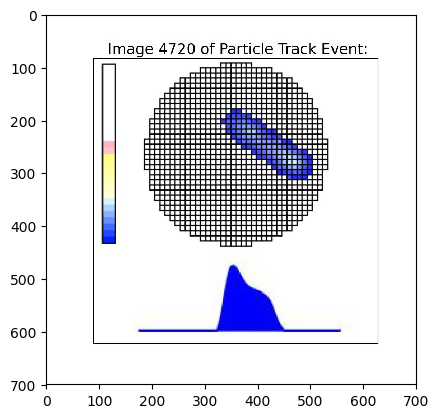

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: could not broadcast input array from shape (74,224,3) into shape (550,700,3)

In [8]:
for i in tqdm(range(len(image_list)*duplication_factor)):
    image = Image.open(image_dir + image_list[i//duplication_factor]) # open image
    image = np.array(image)[:,:,:3] # convert to numpy array
    
    image = aug_padplane(image) # augment padplane
    image = aug_trace(image) # augment trace
    image = aug_ebar(image) # augment energy bar
    
    # save image
    plt.imsave(output_dir + str(i%duplication_factor) + image_list[i//duplication_factor], image)
    #break
#plt.imshow(image)